# Data Pipelines

TensorFlow data pipelines are a powerful tool that can simplify and optimize the process of data preparation, batching and loading for your machine learning models, particularly in the field of computer vision.

In computer vision tasks, data preparation can be a time-consuming and memory-intensive process. The images used for training and validation are often very large in size and need to be preprocessed, resized and transformed into a format suitable for the model. The TensorFlow data pipeline helps automate these steps and makes it easier to use large datasets efficiently.

TensorFlow data pipelines use the `tf.data` module, which provides a flexible and high-performance data pipeline that can handle a variety of data formats. With TensorFlow data pipelines, you can easily load and preprocess large datasets, and batch and shuffle the data for training your model. The pipeline also allows for parallel processing of the data, which can significantly speed up the training process.

In this notebook, we will explore TensorFlow data pipelines in detail, and show you how to use them in your computer vision projects.

Reference: 
- [TensorFlow Data Guide](https://www.tensorflow.org/guide/data) 
- [TensorFlow Image Loading and Preprocessing](https://www.tensorflow.org/tutorials/load_data/images)


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

# The libraries below are built-into python and are used to work with local storage and directories
import os

## Example on Dummy Data

Let's start by creating a simple dataset of 10 numbers and then build a pipeline to process it. We will use the `tf.data.Dataset.from_tensor_slices()` method to create a dataset from a tensor. This method takes a tensor as input and returns a `tf.data.Dataset` object.

This example is meant to illustrate the basic concepts of TensorFlow data pipelines. In practice, you will usually load your data from files or other sources.

In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# create random dataset data using numpy
x = np.random.uniform(low=0, high=1, size=(1000, 5))
# create y using a linear formula with some noise
y = (
    -1 * x[:, 0]
    + 1 * x[:, 1]
    + -1 * x[:, 2]
    + 1 * x[:, 3]
    + -1 * x[:, 4]
    + np.random.normal(loc=0, scale=0.1, size=1000)
)

x.shape, y.shape

((1000, 5), (1000,))

In [5]:
# create train and test sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.2, random_state=seed
)

In [6]:
# function to create tf.data.Dataset from numpy arrays
def create_dataset(x, y):
    # create tf.data.Dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    # shuffle the dataset
    dataset = dataset.shuffle(buffer_size=len(x))
    # batch the dataset
    dataset = dataset.batch(batch_size=8)
    return dataset


# create train and test datasets
train_dataset = create_dataset(x_train, y_train)
test_dataset = create_dataset(x_test, y_test)

2023-01-29 15:07:27.995703: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 15:07:27.996076: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [7]:
# iterate over the dataset, notice that the dataset return batches of data and not single examples
for x_batch, y_batch in train_dataset:
    print(x_batch.shape, y_batch.shape)
    print("Inputs Batch:", x_batch)
    print("Outputs Batch:", y_batch)
    break  # break the loop after the first iteration

(8, 5) (8,)
Inputs Batch: tf.Tensor(
[[0.53157215 0.03265906 0.47559619 0.40774811 0.16121881]
 [0.31577315 0.0568814  0.76652732 0.70210745 0.33135222]
 [0.33424389 0.7709122  0.10659825 0.07513778 0.72818876]
 [0.29335342 0.52547031 0.69783279 0.90026411 0.79219119]
 [0.60754485 0.17052412 0.06505159 0.94888554 0.96563203]
 [0.58064523 0.93593725 0.67225069 0.48127795 0.80967504]
 [0.91985562 0.34634599 0.3469532  0.73750125 0.45221794]
 [0.18527685 0.54127011 0.64557218 0.04558516 0.94597089]], shape=(8, 5), dtype=float64)
Outputs Batch: tf.Tensor(
[-0.78881507 -0.67168966 -0.23385055 -0.4759486  -0.54681815 -0.71925862
 -0.49952118 -1.2057952 ], shape=(8,), dtype=float64)


In [8]:
# create and train a super simple model
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(5,))])

model.compile(optimizer="adam", loss="mae")
model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
    100/Unknown - 1s 9ms/step - loss: 0.5563

2023-01-29 15:07:29.109883: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 1s 11ms/step - loss: 0.5563 - val_loss: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.5243 - val_loss: 0.5106
Epoch 3/100
 98/100 [============================>.] - ETA: 0s - loss: 0.4990

2023-01-29 15:07:29.493970: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.4995 - val_loss: 0.4911
Epoch 4/100
 81/100 [=======================>......] - ETA: 0s - loss: 0.4770

2023-01-29 15:07:29.700550: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:29.874077: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.4779 - val_loss: 0.4721
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.4521 - val_loss: 0.4511
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.4302 - val_loss: 0.4296
Epoch 7/100
  1/100 [..............................] - ETA: 1s - loss: 0.4158

2023-01-29 15:07:30.029927: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:30.186469: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.4101 - val_loss: 0.4076
Epoch 8/100
 88/100 [=========================>....] - ETA: 0s - loss: 0.3915

2023-01-29 15:07:30.342856: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.3862 - val_loss: 0.3869
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3655 - val_loss: 0.3647


2023-01-29 15:07:30.553807: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:30.712152: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3453 - val_loss: 0.3445
Epoch 11/100
100/100 [==============================] - 0s 2ms/step - loss: 0.3229 - val_loss: 0.3242
Epoch 12/100
  1/100 [..............................] - ETA: 1s - loss: 0.3226

2023-01-29 15:07:30.880213: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:31.035197: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.3002 - val_loss: 0.3062
Epoch 13/100
100/100 [==============================] - 0s 2ms/step - loss: 0.2801 - val_loss: 0.2841


2023-01-29 15:07:31.196911: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:31.352925: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 14/100
100/100 [==============================] - 0s 1ms/step - loss: 0.2594 - val_loss: 0.2634
Epoch 15/100
 80/100 [=======================>......] - ETA: 0s - loss: 0.2385

2023-01-29 15:07:31.503434: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.2388 - val_loss: 0.2425
Epoch 16/100
100/100 [==============================] - 0s 2ms/step - loss: 0.2175 - val_loss: 0.2226


2023-01-29 15:07:31.721678: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:31.887136: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 17/100
100/100 [==============================] - 0s 1ms/step - loss: 0.1981 - val_loss: 0.2040
Epoch 18/100
100/100 [==============================] - 0s 1ms/step - loss: 0.1790 - val_loss: 0.1859
Epoch 19/100
  1/100 [..............................] - ETA: 1s - loss: 0.1207

2023-01-29 15:07:32.036025: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:32.182161: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.1604 - val_loss: 0.1666
Epoch 20/100
100/100 [==============================] - 0s 1ms/step - loss: 0.1445 - val_loss: 0.1494
Epoch 21/100
  1/100 [..............................] - ETA: 1s - loss: 0.1131

2023-01-29 15:07:32.340363: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:32.487240: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.1347
Epoch 22/100
 70/100 [====================>.........] - ETA: 0s - loss: 0.1157

2023-01-29 15:07:32.645974: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.1161 - val_loss: 0.1213
Epoch 23/100
100/100 [==============================] - 0s 1ms/step - loss: 0.1047 - val_loss: 0.1113
Epoch 24/100
  1/100 [..............................] - ETA: 1s - loss: 0.0903

2023-01-29 15:07:32.874257: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:33.020725: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0967 - val_loss: 0.1010
Epoch 25/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0902 - val_loss: 0.0954
Epoch 26/100
  1/100 [..............................] - ETA: 1s - loss: 0.0585

2023-01-29 15:07:33.191856: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:33.342654: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 1ms/step - loss: 0.0865 - val_loss: 0.0909
Epoch 27/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0837 - val_loss: 0.0881
Epoch 28/100
  1/100 [..............................] - ETA: 1s - loss: 0.0599

2023-01-29 15:07:33.491017: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:33.636386: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0855
Epoch 29/100
 38/100 [==========>...................] - ETA: 0s - loss: 0.0794

2023-01-29 15:07:33.795496: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0840
Epoch 30/100
 93/100 [==========================>...] - ETA: 0s - loss: 0.0800

2023-01-29 15:07:34.063181: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:34.253225: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0831
Epoch 31/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0827
Epoch 32/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0827


2023-01-29 15:07:34.412397: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:34.572007: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 33/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.0815
Epoch 34/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0791 - val_loss: 0.0827
Epoch 35/100
  1/100 [..............................] - ETA: 1s - loss: 0.0909

2023-01-29 15:07:34.727787: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:34.878615: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 3ms/step - loss: 0.0790 - val_loss: 0.0813
Epoch 36/100
 70/100 [====================>.........] - ETA: 0s - loss: 0.0794

2023-01-29 15:07:35.122743: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.0812
Epoch 37/100
 70/100 [====================>.........] - ETA: 0s - loss: 0.0778

2023-01-29 15:07:35.335144: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:35.535448: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0811
Epoch 38/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0816
Epoch 39/100
 73/100 [====================>.........] - ETA: 0s - loss: 0.0801

2023-01-29 15:07:35.765955: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:35.958341: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0835
Epoch 40/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0813
Epoch 41/100
 62/100 [=================>............] - ETA: 0s - loss: 0.0789

2023-01-29 15:07:36.166756: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 3ms/step - loss: 0.0790 - val_loss: 0.0818
Epoch 42/100
 75/100 [=====================>........] - ETA: 0s - loss: 0.0792

2023-01-29 15:07:36.431599: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0816
Epoch 43/100
 65/100 [==================>...........] - ETA: 0s - loss: 0.0820

2023-01-29 15:07:36.655687: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.0816
Epoch 44/100
 61/100 [=================>............] - ETA: 0s - loss: 0.0801

2023-01-29 15:07:36.864240: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0836
Epoch 45/100
 65/100 [==================>...........] - ETA: 0s - loss: 0.0784

2023-01-29 15:07:37.093097: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0821
Epoch 46/100
 64/100 [==================>...........] - ETA: 0s - loss: 0.0794

2023-01-29 15:07:37.299594: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0815
Epoch 47/100
 67/100 [===================>..........] - ETA: 0s - loss: 0.0790

2023-01-29 15:07:37.501003: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 3ms/step - loss: 0.0791 - val_loss: 0.0818
Epoch 48/100
 32/100 [========>.....................] - ETA: 0s - loss: 0.0810

2023-01-29 15:07:37.707793: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0815
Epoch 49/100
 64/100 [==================>...........] - ETA: 0s - loss: 0.0816

2023-01-29 15:07:37.987034: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:38.188102: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0813
Epoch 50/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0818
Epoch 51/100
 73/100 [====================>.........] - ETA: 0s - loss: 0.0789

2023-01-29 15:07:38.423275: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:38.610465: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0817
Epoch 52/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0824
Epoch 53/100
 67/100 [===================>..........] - ETA: 0s - loss: 0.0765

2023-01-29 15:07:38.835761: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0818
Epoch 54/100
 26/100 [======>.......................] - ETA: 0s - loss: 0.0822

2023-01-29 15:07:39.044387: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 3ms/step - loss: 0.0792 - val_loss: 0.0815
Epoch 55/100
 66/100 [==================>...........] - ETA: 0s - loss: 0.0793

2023-01-29 15:07:39.332753: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0818
Epoch 56/100
 69/100 [===================>..........] - ETA: 0s - loss: 0.0799

2023-01-29 15:07:39.534120: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:39.731635: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0819
Epoch 57/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0815
Epoch 58/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0792 - val_loss: 0.0821
Epoch 59/100
  1/100 [..............................] - ETA: 1s - loss: 0.0613

2023-01-29 15:07:39.894209: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:40.043938: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0817
Epoch 60/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0819
Epoch 61/100
  1/100 [..............................] - ETA: 1s - loss: 0.0810

2023-01-29 15:07:40.200038: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:40.355085: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0816
Epoch 62/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0795 - val_loss: 0.0818
Epoch 63/100
  1/100 [..............................] - ETA: 1s - loss: 0.0891

2023-01-29 15:07:40.570957: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:40.716670: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0814
Epoch 64/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0787 - val_loss: 0.0840
Epoch 65/100
  1/100 [..............................] - ETA: 1s - loss: 0.0869

2023-01-29 15:07:40.877500: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:41.027054: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0822
Epoch 66/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0787 - val_loss: 0.0824
Epoch 67/100
  1/100 [..............................] - ETA: 1s - loss: 0.0846

2023-01-29 15:07:41.196164: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:41.349626: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0819
Epoch 68/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0790 - val_loss: 0.0817
Epoch 69/100
  1/100 [..............................] - ETA: 1s - loss: 0.1073

2023-01-29 15:07:41.497264: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:41.647128: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.0819
Epoch 70/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0791 - val_loss: 0.0814
Epoch 71/100
  1/100 [..............................] - ETA: 1s - loss: 0.0478

2023-01-29 15:07:41.876470: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:42.021445: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0823
Epoch 72/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0841
Epoch 73/100
  1/100 [..............................] - ETA: 1s - loss: 0.0557

2023-01-29 15:07:42.173520: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:42.328853: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0818
Epoch 74/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0788 - val_loss: 0.0850
Epoch 75/100
  1/100 [..............................] - ETA: 1s - loss: 0.0733

2023-01-29 15:07:42.482013: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:42.628000: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 1ms/step - loss: 0.0798 - val_loss: 0.0845
Epoch 76/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0796

2023-01-29 15:07:42.777871: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:42.934681: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0825
Epoch 77/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0838
Epoch 78/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0791 - val_loss: 0.0826
Epoch 79/100
  1/100 [..............................] - ETA: 1s - loss: 0.0856

2023-01-29 15:07:43.135229: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:43.282676: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0818
Epoch 80/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0793 - val_loss: 0.0817
Epoch 81/100
  1/100 [..............................] - ETA: 1s - loss: 0.0545

2023-01-29 15:07:43.438657: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:43.591398: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0839
Epoch 82/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0793 - val_loss: 0.0833
Epoch 83/100
  1/100 [..............................] - ETA: 1s - loss: 0.0755

2023-01-29 15:07:43.743645: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:43.892923: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 3ms/step - loss: 0.0794 - val_loss: 0.0846
Epoch 84/100
 46/100 [============>.................] - ETA: 0s - loss: 0.0772

2023-01-29 15:07:44.209591: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0820
Epoch 85/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0793 - val_loss: 0.0815
Epoch 86/100
  1/100 [..............................] - ETA: 1s - loss: 0.0566

2023-01-29 15:07:44.473926: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:44.628380: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0827
Epoch 87/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0789 - val_loss: 0.0814
Epoch 88/100
  1/100 [..............................] - ETA: 1s - loss: 0.0894

2023-01-29 15:07:44.780478: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:44.925920: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0819
Epoch 89/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0796 - val_loss: 0.0824
Epoch 90/100
  1/100 [..............................] - ETA: 1s - loss: 0.1163

2023-01-29 15:07:45.081755: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:45.230029: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0822
Epoch 91/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0797 - val_loss: 0.0822
Epoch 92/100
  1/100 [..............................] - ETA: 1s - loss: 0.0637

2023-01-29 15:07:45.460249: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:45.605290: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0833
Epoch 93/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0817


2023-01-29 15:07:45.774688: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:45.939130: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 94/100
100/100 [==============================] - 0s 1ms/step - loss: 0.0790 - val_loss: 0.0821
Epoch 95/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0821
Epoch 96/100


2023-01-29 15:07:46.088642: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:46.246647: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0817
Epoch 97/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0832


2023-01-29 15:07:46.411184: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:46.579599: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 98/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0834
Epoch 99/100
 74/100 [=====================>........] - ETA: 0s - loss: 0.0799

2023-01-29 15:07:46.803407: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]
2023-01-29 15:07:46.999100: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


100/100 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0836
Epoch 100/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0815


2023-01-29 15:07:47.162117: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


## Cats vs. Dogs Dataset

Now let's look at a more realistic example. We will use the [Cats vs. Dogs dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs). This dataset contains 2,000 images of cats and dogs, split into 1,000 training images and 1,000 validation images. The images are in JPEG format and have different sizes.

Let's download the dataset and take a look at the images. We will notice that the images have different sizes and that the labels are stored in a separate file and folders. The downloaded dataset structure look something like this:

```
cats_vs_dogs_filtered/
    train/
        cats/
            cat0001.jpg
            cat0002.jpg
            ...
        dogs/
            dog0001.jpg
            dog0002.jpg
            ...
    validation/
        cats/
            cat2001.jpg
            cat2002.jpg
            ...
        dogs/
            dog2001.jpg
            dog2002.jpg
            ...
```

Notice how the folder structure splits the images into training and validation sets, and how the images are stored in separate folders for each class. We will use the `os` module to get the list of files and store them as image paths and labels in a list.

In [ ]:
# download and unzip the dataset
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

In [10]:
# now read the dataset manually using os and put it into a dataframe
# we will create a function to do this so we can reuse it for both the training and validation sets


def read_dataset(path):  # e.g. path = cats_and_dogs_filtered/train

    x = []  # images
    y = []  # labels

    # we will use os.listdir to read the contents of the folder
    labels = os.listdir(path)  # e.g. labels = ["cats", "dogs"]

    # iterate over the labels
    for label in labels:

        # we join the label to the path to get the path to the class folder which contains the images
        label_dir = os.path.join(path, label)  # e.g. cats_and_dogs_filtered/train/cat

        # we will use os.listdir again to read the contents of the class folders (i.e., the images)
        images = os.listdir(label_dir)  # e.g. ["cat.100.jpg", "cat.101.jpg", ...]

        # iterate over the images
        for image in os.listdir(label_dir):

            # we join the image name to the path to get the path to the image
            image_path = os.path.join(
                label_dir, image
            )  # e.g. cats_and_dogs_filtered/train/cats/cat.100.jpg

            # append the image path and the label to the lists
            x.append(image_path)
            y.append(label)

    # return a dataframe with the image paths and labels
    return pd.DataFrame({"image": x, "label": y})


# read the training and validation sets
train_df = read_dataset("cats_and_dogs_filtered/train")
val_df = read_dataset("cats_and_dogs_filtered/validation")

In [ ]:
train_df.head()

,image,label
0,cats_and_dogs_filtered/train/dogs/dog.775.jpg,dogs
1,cats_and_dogs_filtered/train/dogs/dog.761.jpg,dogs
2,cats_and_dogs_filtered/train/dogs/dog.991.jpg,dogs
3,cats_and_dogs_filtered/train/dogs/dog.749.jpg,dogs
4,cats_and_dogs_filtered/train/dogs/dog.985.jpg,dogs


Currently the dataset is a piar of iamge paths and labels. We will need to transform the image paths into tensors and resize them to a uniform size. We will also need to convert the labels into integers (0 for cats and 1 for dogs). We don't need to one-hot encode the labels because the classification is binary.

Before creating the dataset, we will create maping functions that will transform the dataset. The `map()` method allows us to apply a function to each element of the dataset. We will use the `map()` method to apply the mapping functions to the dataset.

Note that any map function we create for the purpose of mapping a dataset of input and output pairs (x, y) must take two arguments: x and y and return two values: x and y. The `map()` method will apply the function to each element of the dataset, and the function must be able to handle both the input and the output.

We will now create 3 functions:
    - image_to_tensor: This function will take an image path as input and return the image as a tensor.
    - image_augmentation: This function will take an image tensor as input and return the augmented image tensor.
    - label_encoder: This function will take a label as input and return the encoded label.

In [11]:
def image_to_tensor(x, y):
    # read the image from the path
    img = tf.io.read_file(x)
    # decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image
    img = tf.image.resize(img, [224, 224])
    # normalize the image
    img = img / 255.0
    return img, y

In [12]:
def image_augmentation(x, y):
    # randomly flip the image horizontally
    img = tf.image.random_flip_left_right(x)
    # randomly flip the image vertically
    img = tf.image.random_flip_up_down(img)
    # randomly change the brightness of the image
    img = tf.image.random_brightness(img, max_delta=0.2)
    # clip the image to be between 0 and 1
    img = tf.clip_by_value(img, 0, 1)
    return img, y

In [13]:
def label_encoder(x, y):
    if y == "dogs":
        label = 1
    else:
        label = 0

    return x, label

In [14]:
# We will create a function that takes input output pairs and returns a tf.data.Dataset
def tf_dataset_creator(x, y, training=False):

    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(image_to_tensor)
    dataset = dataset.map(label_encoder)
    if training:  # only augment the training set
        dataset = dataset.map(image_augmentation)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)

    return dataset


# create the training and validation datasets
train_dataset = tf_dataset_creator(train_df["image"], train_df["label"], training=True)
val_dataset = tf_dataset_creator(val_df["image"], val_df["label"])

(32, 224, 224, 3) (32,)


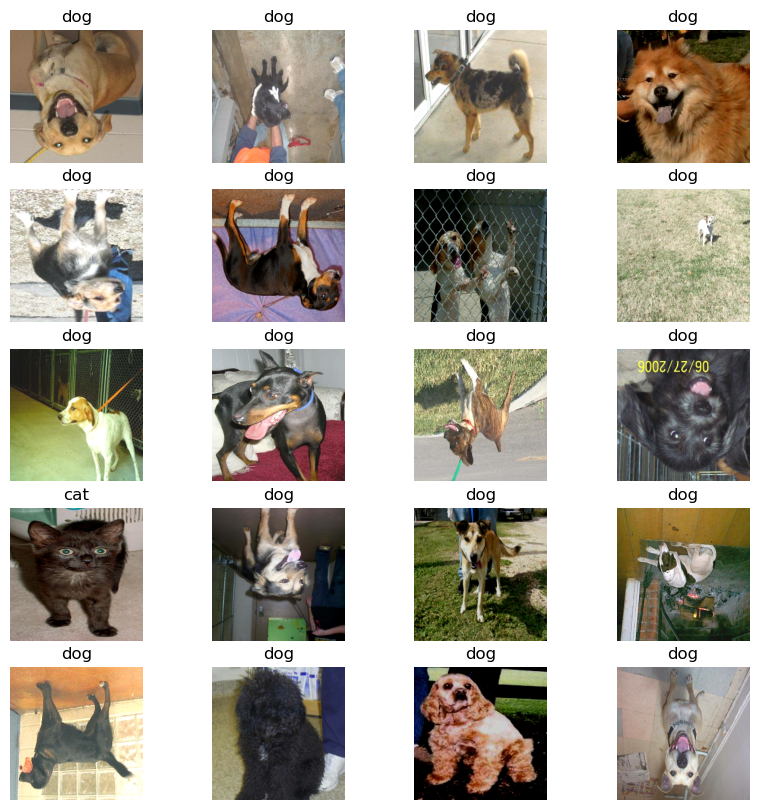

In [15]:
# preview a sample of the images from trian_dataset
for x, y in train_dataset:
    print(x.shape, y.shape)
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(5, 4, i + 1)
        plt.imshow(x[i])
        plt.title("cat" if int(y[i]) == 0 else "dog")
        plt.axis("off")
    plt.show()
    break

### Vanilla CNN Model

Now that we have created the dataset, we can build a simple CNN model to classify the images. We will use the `tf.keras.Sequential` API to build the model. We will use the `tf.keras.layers.Conv2D` layer to add convolutional layers to the model. We will use the `tf.keras.layers.MaxPool2D` layer to add pooling layers to the model. We will use the `tf.keras.layers.Flatten` layer to flatten the output of the last convolutional layer. We will use the `tf.keras.layers.Dense` layer to add fully connected layers to the model.

In [ ]:
# build a simple model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(224, 224, 3)
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# compile
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

### Transfer Learning VGG16 Model

We will now use transfer learning to build a more powerful model. We will use the VGG16 model as a base model and add a few fully connected layers on top of it. We will freeze the base model and train only the top layers.

In [ ]:
# load base model
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)

# freeze the base model
base_model.trainable = False

# create a new model on top

model2 = tf.keras.Sequential(
    [
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# compile
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train
model2.fit(train_dataset, epochs=10, validation_data=val_dataset)